Train Regression (3 CLIP scores, and T -> predict best T) Model

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import os
import random

random_seed = 42
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
np.random.seed(random_seed)
random.seed(random_seed)

os.environ["CUDA_VISIBLE_DEVICES"] = '1'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [5]:
t=np.linspace(2, 5, 30)

print(t)

[2.         2.10344828 2.20689655 2.31034483 2.4137931  2.51724138
 2.62068966 2.72413793 2.82758621 2.93103448 3.03448276 3.13793103
 3.24137931 3.34482759 3.44827586 3.55172414 3.65517241 3.75862069
 3.86206897 3.96551724 4.06896552 4.17241379 4.27586207 4.37931034
 4.48275862 4.5862069  4.68965517 4.79310345 4.89655172 5.        ]


Load Data

In [4]:
save_path = Path('/home/lbw/CLODE/scores_csv_4prompts_400600')
# save_path = Path('/home/lbw/CLODE/scores_csv_15_45')

# (485, 2): 485개 이미지에 대한, best T값과 그때의 PSNR
results = np.load(save_path / 'results.npy')

# (485 * 30, 3): 485개 이미지에 대한, 30개의 T값에 대한 score. 3 = [idx, T, score]
brightness_scores = np.load(save_path / 'brightness_scores.npy')
noisiness_scores = np.load(save_path / 'noisiness_scores.npy')
quality_scores = np.load(save_path / 'quality_scores.npy')

print(results.shape, brightness_scores.shape, noisiness_scores.shape, quality_scores.shape)

(485, 2) (14550, 3) (14550, 3) (14550, 3)


In [5]:
print(brightness_scores[:31, 1])

[2.         2.10344828 2.20689655 2.31034483 2.4137931  2.51724138
 2.62068966 2.72413793 2.82758621 2.93103448 3.03448276 3.13793103
 3.24137931 3.34482759 3.44827586 3.55172414 3.65517241 3.75862069
 3.86206897 3.96551724 4.06896552 4.17241379 4.27586207 4.37931034
 4.48275862 4.5862069  4.68965517 4.79310345 4.89655172 5.
 2.        ]


In [6]:
NUM_IMAGES = results.shape[0]
NUM_T = 30

In [5]:
# from torchmetrics.multimodal import CLIPImageQualityAssessment
# from tqdm import tqdm
# from misc import *

# prompts = ('brightness', 'noisiness', 'quality')
# clip_metric = CLIPImageQualityAssessment(model_name_or_path="openai/clip-vit-base-patch16", prompts=prompts).to(device)

# file_path = Path('/home/soom/data/our485')
# img_labels = sorted(os.listdir(file_path / 'low'))

# def calculate_clip_scores(pred):    
#     clip_result = clip_metric(pred.unsqueeze(0) if len(pred.shape) == 3 else pred)
#     scores = [clip_result[prompt].item() for prompt in prompts]
    
#     return scores

# lq_iqa_scores = []

# with torch.no_grad():
#     for idx in tqdm(range(NUM_IMAGES)):
#         lq_t = image_tensor(file_path / 'low' / img_labels[idx], size=(256, 256))
#         scores = calculate_clip_scores(lq_t)
#         lq_iqa_scores.append(scores)

In [6]:
lq_iqa_scores = np.load(Path('/home/soom/CLODE/soom_npy_results') / 'lq_iqa_scores.npy')

In [7]:
X = np.zeros((NUM_IMAGES, NUM_T, 3))

for i in range(NUM_IMAGES):
    for j in range(NUM_T):
        X[i, j, 0] = brightness_scores[i * NUM_T + j, 2]
        X[i, j, 1] = noisiness_scores[i * NUM_T + j, 2]
        X[i, j, 2] = quality_scores[i * NUM_T + j, 2]

y = results[:, 0]

X = torch.tensor(X, dtype=torch.float32).to(device)
y = torch.tensor(y, dtype=torch.float32).to(device)

print(X.shape, y.shape)

torch.Size([485, 30, 3]) torch.Size([485])


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

torch.Size([388, 30, 3]) torch.Size([97, 30, 3]) torch.Size([388]) torch.Size([97])


In [ ]:
batch_size = 16
train_loader = torch.utils.data.DataLoader(list(zip(X_train, y_train)), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(list(zip(X_test, y_test)), batch_size=batch_size, shuffle=False)

: 

Load Model

In [9]:
class Regressor(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=64):
        super(Regressor, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            # nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            # nn.LayerNorm(hidden_dim),
        )

        self.transformer_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=4, dim_feedforward=hidden_dim*2)
        self.transformer = nn.TransformerEncoder(self.transformer_layer, num_layers=2)

        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1)
        )

    def forward(self, x):
        # [batch_size, T, hidden_dim]
        x = self.mlp(x)
        # [seq_len = T, batch, hidden_dim]
        x = x.permute(1, 0, 2)
        x = self.transformer(x)
        # [batch, hidden_dim]
        x = x.permute(1, 0, 2).mean(dim=1)
        # [batch, 1]
        T_pred = self.fc(x).squeeze(-1)
        return T_pred

Train the Model

In [13]:
from tqdm import tqdm

num_epochs = 2000
train_losses = []
test_losses = []
best_test_loss = 10
best_epoch = 0
learning_rate = 1e-4

regressor = Regressor(input_dim = 3, hidden_dim = 64).to(device)
criterion = torch.nn.HuberLoss(delta=1.0)
optimizer = optim.AdamW(regressor.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)


for epoch in tqdm(range(num_epochs)):
    regressor.train()
    epoch_loss = 0.0
    
    for X_batch, y_batch in train_loader:
        y_pred = regressor(X_batch)
        loss = criterion(y_pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    train_losses.append(epoch_loss / len(train_loader))
    
    regressor.eval()
    test_loss = 0.0
    with torch.no_grad():
        total = 0
        correct = 0
        total_loss = 0
        
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            y_pred = regressor(X_batch)
            test_loss += criterion(y_pred, y_batch).item()
    
    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    
    if test_loss < best_test_loss:
            best_test_loss = test_loss
            best_model = regressor.state_dict()
            best_epoch = epoch


model_path = Path("/home/lbw/CLODE/lbw_outputs")
model_path.mkdir(exist_ok=True, parents=True)

torch.save(best_model, (model_path / f'att_regression_46_{best_epoch}.pth'))
print(best_epoch)

/home/lbw/miniconda3/envs/CLODE_128_bw/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/home/lbw/miniconda3/envs/CLODE_128_bw/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
100%|██████████| 2000/2000 [08:12<00:00,  4.06it/s]

382


Plot Train Result and Performance

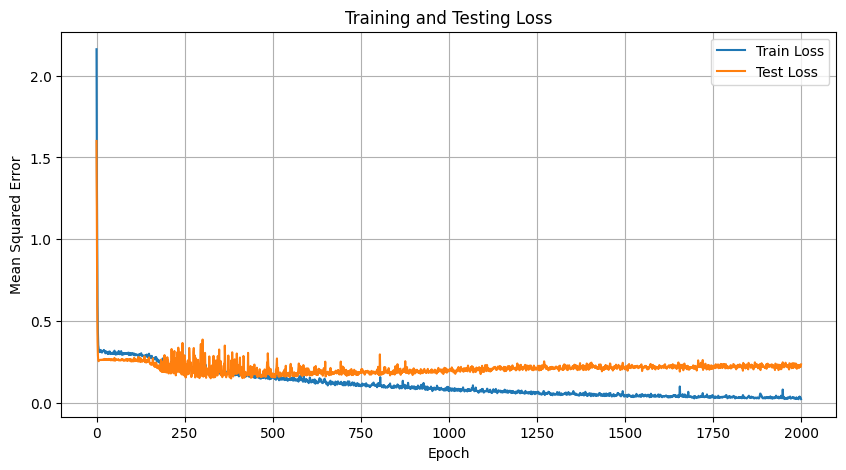

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Training and Testing Loss')
plt.legend()
plt.grid(True)
plt.savefig(model_path / 'regression_training.png')
plt.show()

MAE: 0.1961, RMSE: 0.2521


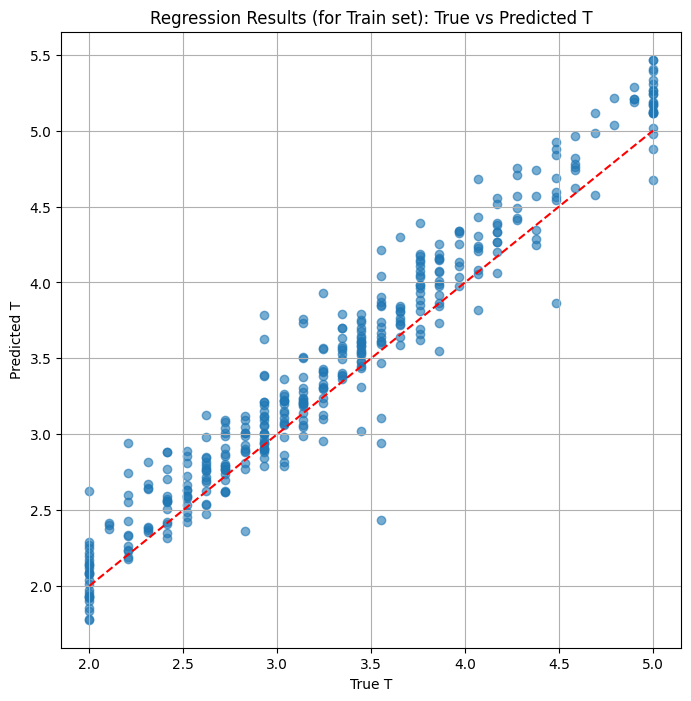

MAE: 0.5682, RMSE: 0.7308


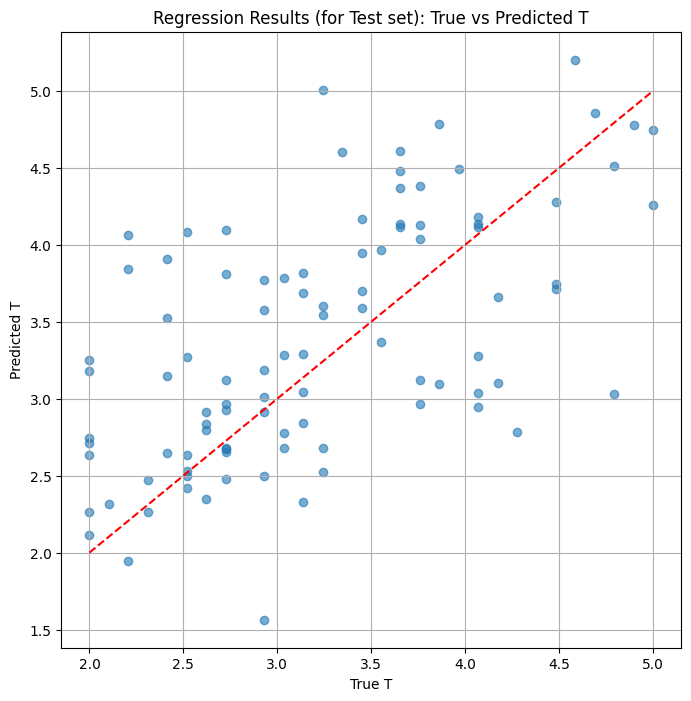

In [15]:
regressor.eval()

def plot_regression_results(y_true, y_pred, title):
    mae = np.mean(np.abs(y_pred - y_true))
    rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))
    
    print(f'MAE: {mae:.4f}, RMSE: {rmse:.4f}')

    plt.figure(figsize=(8, 8))
    plt.scatter(y_true, y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel('True T')
    plt.ylabel('Predicted T')
    plt.title(title)
    plt.grid(True)
    plt.show()

with torch.no_grad():
    y_pred = regressor(X_train).cpu().numpy()
    y_true = y_train.cpu().numpy()
    
    plot_regression_results(y_true, y_pred, 'Regression Results (for Train set): True vs Predicted T')

    y_pred = regressor(X_test).cpu().numpy()
    y_true = y_test.cpu().numpy()
    
    plot_regression_results(y_true, y_pred, 'Regression Results (for Test set): True vs Predicted T')

In [32]:
import torch
from tqdm import tqdm
from network.conv_node import NODE
# from network.clip_classifier import TtoTClassifier
from misc import *
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from torchmetrics.multimodal import CLIPImageQualityAssessment
import time
from network.clip_regressor import TtoTRegressor
from skimage.metrics import structural_similarity as ssim
import pickle

# GPU 번호 지정
gpu_number = 1  # 원하는 GPU 번호로 변경 가능

# GPU 사용 제한
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_number)

# 이제 GPU가 한 개만 보이므로 cuda:0으로 접근
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# 결과 저장 및 로드를 위한 디렉토리 설정
results_save_dir = Path('/home/lbw/eval_CLODE_results')
results_save_dir.mkdir(parents=True, exist_ok=True)

# 시각화 결과 저장 디렉토리
results_dir = Path('/home/lbw/CLODE_eval_results_atten')
results_dir.mkdir(parents=True, exist_ok=True)

# 결과 파일 경로 설정
node_results_file = results_save_dir / 'node_eval_results_64_ssim.pkl'

# 필요한 함수들 정의
def tensor_to_numpy(tensor):
    """PyTorch 텐서를 NumPy 배열로 변환합니다."""
    # GPU -> CPU 이동 및 계산 그래프에서 분리
    img = tensor.detach().cpu().numpy()
    
    # 이미지 형식 변환 (C,H,W) -> (H,W,C)
    if img.ndim == 3 and img.shape[0] == 3:
        img = np.transpose(img, (1, 2, 0))
    
    # 값 범위 조정 [0, 1]
    img = np.clip(img, 0, 1)
    
    return img

# def calculate_ssim(img1, img2):
#     """
#     두 이미지 간의 SSIM(구조적 유사성) 계산
#     """
#     # GPU 텐서를 CPU로 이동 후 NumPy 배열로 변환
#     # 차원 확인 및 정규화
#     if len(img1.shape) == 4:  # (B,C,H,W) 형태인 경우
#         img1 = img1[0]  # (C,H,W) 형태로 변경
#     if len(img2.shape) == 4:  # (B,C,H,W) 형태인 경우
#         img2 = img2[0]  # (C,H,W) 형태로 변경
    
#     img1_np = tensor_to_numpy(img1)
#     img2_np = tensor_to_numpy(img2)
    
#     # tensor_to_numpy 함수를 통해 이미 (H,W,C) 형태로 변환되었으므로
#     # channel_axis는 2로 설정
#     return ssim(img1_np, img2_np, channel_axis=2, data_range=1.0)

# CLIP 점수 계산을 위한 설정
prompts = ('brightness', 'noisiness', 'quality')
clip_metric = CLIPImageQualityAssessment(
    model_name_or_path="openai/clip-vit-base-patch16",
    prompts=prompts
).to(device)

def calculate_clip_score(pred):    
    if len(pred.shape) == 3:
        pred = pred.unsqueeze(0)
    
    with torch.no_grad():
        scores = clip_metric(pred)
    
    return scores[prompts[0]].item(), scores[prompts[1]].item(), scores[prompts[2]].item()

# eval15 데이터 경로 설정
eval_path = Path('/home/lbw/data/eval15')
eval_images = [f for f in sorted(os.listdir(eval_path / 'low')) if f.lower().endswith('.png')]

def load_eval_image(idx):
    img_name = eval_images[idx]
    # lq_img = image_tensor(eval_path / 'low' / img_name, size=(256, 256))
    # gt_img = image_tensor(eval_path / 'high' / img_name, size=(256, 256))
    lq_img = image_tensor(eval_path / 'low' / img_name)
    gt_img = image_tensor(eval_path / 'high' / img_name)
    
    return lq_img.to(device), gt_img.to(device), img_name

In [34]:
import torch
import torch.nn as nn
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import os
import pickle
from tqdm import tqdm

results_save_dir = Path('/home/lbw/eval_CLODE_results')
node_results_file = results_save_dir / 'node_eval_results_64_ssim.pkl'

# 저장된 NODE 결과 로드
try:
    print(f"저장된 NODE 결과를 {node_results_file}에서 로드합니다.")
    with open(node_results_file, 'rb') as f:
        node_results = pickle.load(f)
    print("NODE 결과 로드 완료!")
    
    # T값 로드
    T_values = node_results['T_values']

except FileNotFoundError:
    print(f"결과 파일({node_results_file})을 찾을 수 없습니다.")
    print("NODE 모델 결과를 먼저 생성해야 합니다.")
except Exception as e:
    print(f"결과 로드 중 오류 발생: {e}")

clip_results_256_path = '/home/lbw/eval_CLODE_results/node_eval_results.pkl'

# 저장된 NODE 결과 로드
try:
    print(f"저장된 NODE 결과를 {clip_results_256_path}에서 로드합니다.")
    with open(clip_results_256_path, 'rb') as f:
        clip_results_256 = pickle.load(f)
    print("NODE 결과 로드 완료!")
except FileNotFoundError:
    print(f"결과 파일({clip_results_256_path})을 찾을 수 없습니다.")
    print("NODE 모델 결과를 먼저 생성해야 합니다.")
except Exception as e:
    print(f"결과 로드 중 오류 발생: {e}")

# node_results = node_results['results']
# node_results[0]['clip_scores']

# clip_resluts_256_result = clip_results_256['results']
# clip_resluts_256_result[0]['clip_scores']
print(f"첫 번째 이미지의 교체된 CLIP 점수: {node_results['results'][0]['clip_scores']}")

# NODE 결과의 clip_scores를 clip_results_256의 clip_scores로 교체
for i in range(len(node_results['results'])):
    # 각 이미지에 대해 clip_scores 교체
    node_results['results'][i]['clip_scores'] = clip_results_256['results'][i]['clip_scores']
    
print("CLIP 점수가 성공적으로 교체되었습니다.")
print(f"첫 번째 이미지의 교체된 CLIP 점수: {node_results['results'][0]['clip_scores']}")

# 필요하다면 교체된 데이터를 다시 저장할 수 있습니다
# 새 파일 이름 정의
updated_node_results_file = results_save_dir / 'node_eval_results_64_with_256_clips.pkl'

# 원본 구조에 맞게 결과 재구성
updated_data = node_results

# 교체된 데이터 저장
with open(updated_node_results_file, 'wb') as f:
    pickle.dump(updated_data, f)
print(f"교체된 데이터가 {updated_node_results_file}에 저장되었습니다.")


저장된 NODE 결과를 /home/lbw/eval_CLODE_results/node_eval_results_64_ssim.pkl에서 로드합니다.
NODE 결과 로드 완료!
저장된 NODE 결과를 /home/lbw/eval_CLODE_results/node_eval_results.pkl에서 로드합니다.
NODE 결과 로드 완료!
첫 번째 이미지의 교체된 CLIP 점수: [[0.17501117289066315, 0.38613617420196533, 0.5825388431549072], [0.1726592630147934, 0.38721051812171936, 0.580739438533783], [0.17062591016292572, 0.3880743384361267, 0.5788583755493164], [0.16895842552185059, 0.3889525234699249, 0.5768758058547974], [0.16778624057769775, 0.3901522159576416, 0.5748540163040161], [0.16671010851860046, 0.3913637101650238, 0.5724828243255615], [0.16611717641353607, 0.3925369083881378, 0.569717526435852], [0.16561946272850037, 0.39385756850242615, 0.5665863156318665], [0.16526998579502106, 0.3948233425617218, 0.5628589391708374], [0.16494345664978027, 0.39570096135139465, 0.558361291885376], [0.16474178433418274, 0.3961680829524994, 0.5534892678260803], [0.1645665466785431, 0.3958943486213684, 0.5480991005897522], [0.16439852118492126, 0.3957547545433

In [41]:
# updated_node_results_file

# 저장된 NODE 결과 로드
try:
    print(f"저장된 NODE 결과를 {updated_node_results_file}에서 로드합니다.")
    with open(updated_node_results_file, 'rb') as f:
        new_node_results = pickle.load(f)
    print("NODE 결과 로드 완료!")
    
    # T값 로드
    T_values = new_node_results['T_values']

except FileNotFoundError:
    print(f"결과 파일({updated_node_results_file})을 찾을 수 없습니다.")
    print("NODE 모델 결과를 먼저 생성해야 합니다.")
except Exception as e:
    print(f"결과 로드 중 오류 발생: {e}")

a = new_node_results
aa = new_node_results['results'][0]['clip_scores']

max_psnrs = []  
max_ssims = []
max_combined = []  # PSNR + 10*SSIM을 위한 리스트
max_combined_psnr = []  # PSNR + 10*SSIM을 위한 리스트
max_combined_ssim = []  # PSNR + 10*SSIM을 위한 리스트

# 각 이미지에 대해 최대 PSNR 및 SSIM 인덱스 찾기
for idx in range(15):  # 0부터 14까지
    img_result = new_node_results['results'][idx]
    
    # PSNR 및 SSIM 값 가져오기
    psnrs = img_result['psnrs']
    ssims = img_result['ssims']
    
    # 결합된 메트릭 계산 (PSNR + 10*SSIM)
    combined_metrics = [psnr + 10*ssim for psnr, ssim in zip(psnrs, ssims)]
    
    # 각 메트릭의 최대값 인덱스 찾기
    max_psnr_idx = np.argmax(psnrs)
    max_ssim_idx = np.argmax(ssims)
    max_combined_idx = np.argmax(combined_metrics)
    
    # 최대값 가져오기
    max_psnr = psnrs[max_psnr_idx]
    max_ssim = ssims[max_ssim_idx]
    max_combined_psnr_value = psnrs[max_combined_idx]
    max_combined_ssim_value = ssims[max_combined_idx]
    max_combined_value = combined_metrics[max_combined_idx]
    
    # 해당하는 T값 찾기
    best_T_psnr = T_values[max_psnr_idx]
    best_T_ssim = T_values[max_ssim_idx]
    best_T_combined = T_values[max_combined_idx]
    
    # 리스트에 최대값 추가
    max_psnrs.append(max_psnr)
    max_ssims.append(max_ssim)
    max_combined_psnr.append(max_combined_psnr_value)
    max_combined_ssim.append(max_combined_ssim_value)
    max_combined.append(max_combined_value)
    
    print(f"이미지 {idx}:")
    print(f"  최대 PSNR: {max_psnr:.4f}dB (인덱스: {max_psnr_idx}, T값: {best_T_psnr:.4f})")
    print(f"  최대 SSIM: {max_ssim:.4f} (인덱스: {max_ssim_idx}, T값: {best_T_ssim:.4f})")
    print(f"  최대 PSNR: {max_combined_psnr_value:.4f}dB  최대 SSIM: {max_combined_ssim_value:.4f}  최대 결합(PSNR+10*SSIM): {max_combined_value:.4f} (인덱스: {max_combined_idx}, T값: {best_T_combined:.4f})")
    
    # 인덱스 비교
    if max_psnr_idx == max_ssim_idx and max_psnr_idx == max_combined_idx:
        print(f"  👍 모든 메트릭이 같은 T값에서 최대")
    elif max_psnr_idx == max_combined_idx:
        print(f"  ⚠️ PSNR과 결합 메트릭은 같은 T값, SSIM은 다른 T값에서 최대")
    elif max_ssim_idx == max_combined_idx:
        print(f"  ⚠️ SSIM과 결합 메트릭은 같은 T값, PSNR은 다른 T값에서 최대")
    else:
        print(f"  ⚠️ 모든 메트릭이 서로 다른 T값에서 최대")
        
    print()

# 각 메트릭의 평균 계산
max_psnr_mean = np.mean(max_psnrs)
max_ssim_mean = np.mean(max_ssims)
max_combined_psnr_mean = np.mean(max_combined_psnr)
max_combined_ssim_mean = np.mean(max_combined_ssim)
max_combined_mean = np.mean(max_combined)

print(f"모든 이미지의 평균 PSNR: {max_psnr_mean:.4f}dB")
print(f"모든 이미지의 평균 SSIM: {max_ssim_mean:.4f}")
print(f"모든 이미지의 평균 결합 메트릭(PSNR+10*SSIM): {max_combined_mean:.4f}")
print(f"모든 이미지의 평균 결합 메트릭(PSNR): {max_combined_psnr_mean:.4f}")
print(f"모든 이미지의 평균 결합 메트릭(SSIM): {max_combined_ssim_mean:.4f}")

# 메트릭별 최적 T값 수집
best_Ts_psnr = [T_values[np.argmax(new_node_results['results'][i]['psnrs'])] for i in range(15)]
best_Ts_ssim = [T_values[np.argmax(new_node_results['results'][i]['ssims'])] for i in range(15)]
best_Ts_combined = [T_values[np.argmax([p + 10*s for p, s in zip(new_node_results['results'][i]['psnrs'], new_node_results['results'][i]['ssims'])])] for i in range(15)]

# T값 통계
print(f"\nPSNR 기준 최적 T값 평균: {np.mean(best_Ts_psnr):.4f}")
print(f"SSIM 기준 최적 T값 평균: {np.mean(best_Ts_ssim):.4f}")
print(f"결합 메트릭 기준 최적 T값 평균: {np.mean(best_Ts_combined):.4f}")

저장된 NODE 결과를 /home/lbw/eval_CLODE_results/node_eval_results_64_with_256_clips.pkl에서 로드합니다.
NODE 결과 로드 완료!
이미지 0:
  최대 PSNR: 22.1584dB (인덱스: 8, T값: 2.8276)
  최대 SSIM: 0.7525 (인덱스: 4, T값: 2.4138)
  최대 PSNR: 22.1584dB  최대 SSIM: 0.7355  최대 결합(PSNR+10*SSIM): 29.5135 (인덱스: 8, T값: 2.8276)
  ⚠️ PSNR과 결합 메트릭은 같은 T값, SSIM은 다른 T값에서 최대

이미지 1:
  최대 PSNR: 24.4001dB (인덱스: 11, T값: 3.1379)
  최대 SSIM: 0.7354 (인덱스: 11, T값: 3.1379)
  최대 PSNR: 24.4001dB  최대 SSIM: 0.7354  최대 결합(PSNR+10*SSIM): 31.7538 (인덱스: 11, T값: 3.1379)
  👍 모든 메트릭이 같은 T값에서 최대

이미지 2:
  최대 PSNR: 25.3176dB (인덱스: 8, T값: 2.8276)
  최대 SSIM: 0.8085 (인덱스: 7, T값: 2.7241)
  최대 PSNR: 25.3176dB  최대 SSIM: 0.8084  최대 결합(PSNR+10*SSIM): 33.4013 (인덱스: 8, T값: 2.8276)
  ⚠️ PSNR과 결합 메트릭은 같은 T값, SSIM은 다른 T값에서 최대

이미지 3:
  최대 PSNR: 20.6286dB (인덱스: 0, T값: 2.0000)
  최대 SSIM: 0.7702 (인덱스: 0, T값: 2.0000)
  최대 PSNR: 20.6286dB  최대 SSIM: 0.7702  최대 결합(PSNR+10*SSIM): 28.3304 (인덱스: 0, T값: 2.0000)
  👍 모든 메트릭이 같은 T값에서 최대

이미지 4:
  최대 PSNR: 23.6832dB (인덱스: 10, T값: 3.034

저장된 NODE 결과를 /home/lbw/eval_CLODE_results/node_eval_results_64_with_256_clips.pkl에서 로드합니다.


/home/lbw/miniconda3/envs/CLODE_128_bw/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/tmp/ipykernel_3589773/2812628068.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_s

NODE 결과 로드 완료!


회귀 모델 평가 중: 100%|██████████| 15/15 [00:32<00:00,  2.15s/it]


모든 이미지 처리 완료!


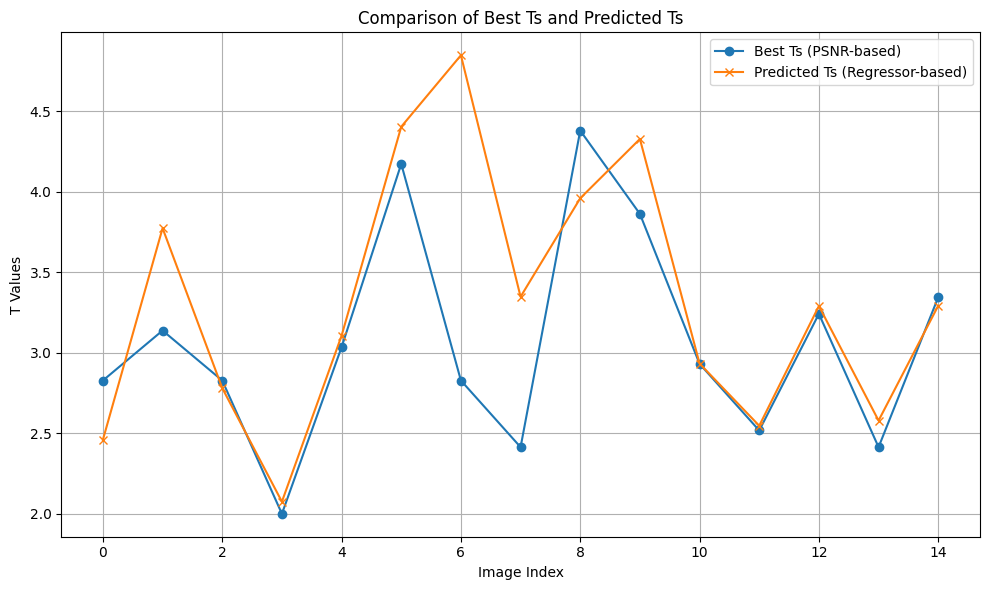

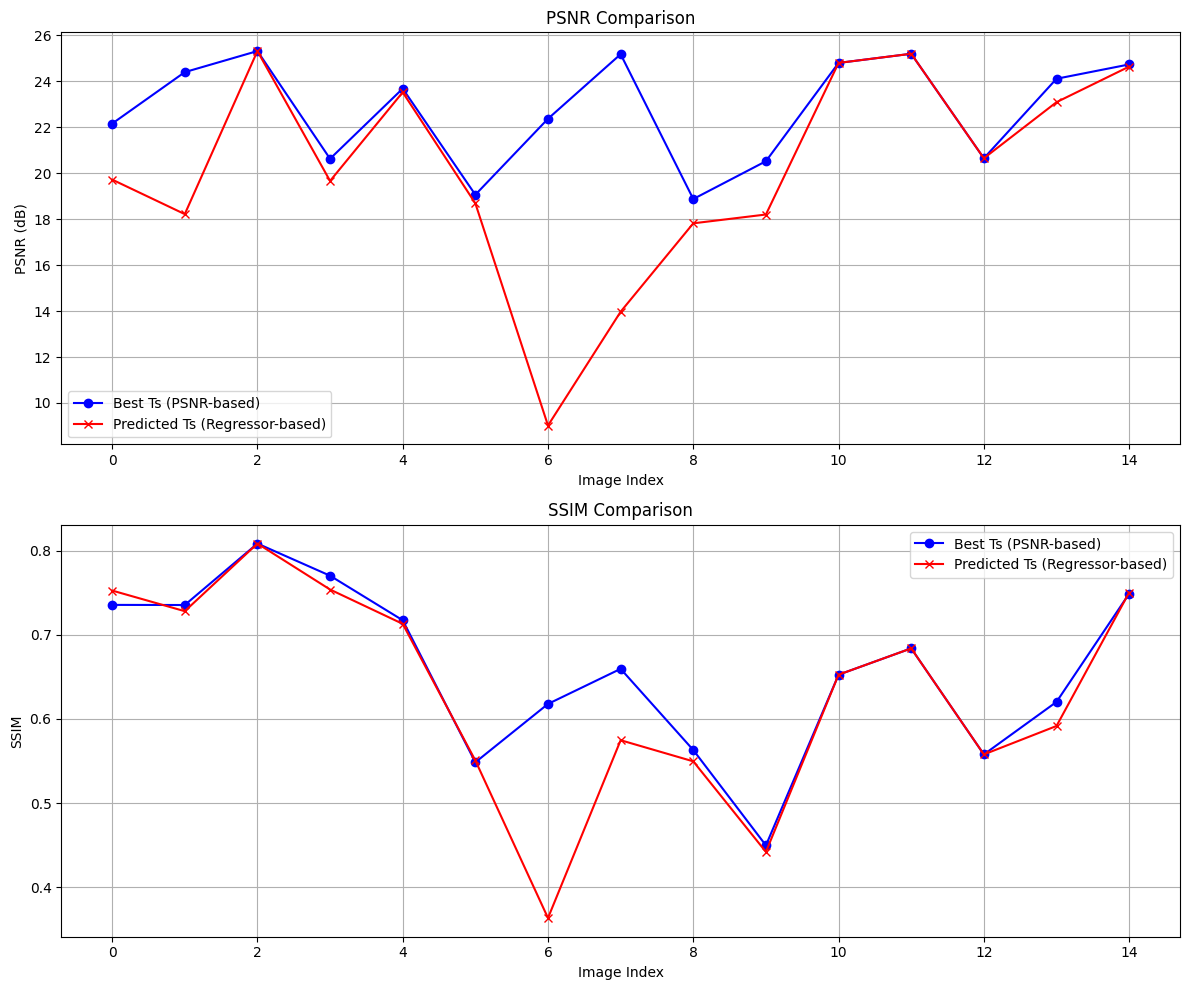

Best T PSNR 평균: 22.7801dB
Predicted T PSNR 평균: 20.1691dB
Best T SSIM 평균: 0.6579
Predicted T SSIM 평균: 0.6315
PSNR 차이(평균): 2.6109dB
SSIM 차이(평균): 0.0264


In [36]:
import torch
import torch.nn as nn
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import os
import pickle
from tqdm import tqdm

node_results_file = results_save_dir / 'node_eval_results_64_with_256_clips.pkl'

# 저장된 NODE 결과 로드
try:
    print(f"저장된 NODE 결과를 {node_results_file}에서 로드합니다.")
    with open(node_results_file, 'rb') as f:
        node_results = pickle.load(f)
    print("NODE 결과 로드 완료!")
    
    # T값 로드
    T_values = node_results['T_values']

except FileNotFoundError:
    print(f"결과 파일({node_results_file})을 찾을 수 없습니다.")
    print("NODE 모델 결과를 먼저 생성해야 합니다.")
except Exception as e:
    print(f"결과 로드 중 오류 발생: {e}")

# 하이퍼파라미터 설정
input_dim = 3
hidden_dim = 64
# num_layers = 3

# 회귀 모델 초기화
regressor = Regressor(input_dim, hidden_dim).to(device)
regressor.eval()
# model_path_name = (model_path / f'att_regression_46_{best_epoch}.pth')
model_path_name = '/home/lbw/CLODE/lbw_outputs/att_regression_298.pth'
regressor.load_state_dict(torch.load(model_path_name, map_location=device))

# 결과 저장 리스트
best_Ts = []
pred_Ts = []
best_psnrs = []
pred_psnrs = []
best_ssims = []
pred_ssims = []



# 이미지별 회귀 모델 평가
for img_idx, img_result in enumerate(tqdm(node_results['results'], desc="회귀 모델 평가 중")):
    img_name = img_result['img_name']
    
    # NODE 결과에서 정보 추출
    best_T_idx = img_result['best_T_idx']
    best_T = img_result['best_T']
    best_psnr = img_result['psnrs'][best_T_idx]
    best_ssim = img_result['ssims'][best_T_idx]
    
    # 결과 저장
    best_Ts.append(best_T)
    best_psnrs.append(best_psnr)
    best_ssims.append(best_ssim)
    
    # CLIP 점수로 T값 예측
    clip_scores = np.array(img_result['clip_scores'])
    clip_scores_tensor = torch.FloatTensor(clip_scores).unsqueeze(0).to(device)  # (1, T, 3)
    
    with torch.no_grad():
        pred_T = regressor(clip_scores_tensor)
        pred_T = pred_T.item()
    
    # 가장 가까운 T값 인덱스 찾기
    pred_T_idx = np.argmin(np.abs(T_values - pred_T))
    
    # 예측 결과 저장
    pred_Ts.append(pred_T)
    pred_psnrs.append(img_result['psnrs'][pred_T_idx])
    pred_ssims.append(img_result['ssims'][pred_T_idx])
    
    # 결과 시각화
    plt.figure(figsize=(20, 15))
    
    # 원본 저화질 이미지
    plt.subplot(2, 2, 1)
    plt.imshow(img_result['lq_img'])
    plt.title(f'Low Quality Image: {img_name}')
    plt.axis('off')
    
    # 원본 고화질 이미지
    plt.subplot(2, 2, 2)
    plt.imshow(img_result['gt_img'])
    plt.title('Ground Truth')
    plt.axis('off')
    
    # PSNR 기반 best_T 이미지
    plt.subplot(2, 2, 3)
    plt.imshow(img_result['preds'][best_T_idx])
    plt.title(f'NODE Best T={best_T:.2f}, PSNR={best_psnr:.2f}dB, SSIM={best_ssim:.4f}')
    plt.axis('off')
    
    # Regressor 예측 T 이미지
    plt.subplot(2, 2, 4)
    plt.imshow(img_result['preds'][pred_T_idx])
    plt.title(f'Regressor Pred T={pred_T:.2f}, PSNR={img_result["psnrs"][pred_T_idx]:.2f}dB, SSIM={img_result["ssims"][pred_T_idx]:.4f}')
    plt.axis('off')
    
    # 결과 저장
    plt.tight_layout()
    plt.savefig(results_dir / f'{img_name.split(".")[0]}_compare.png')
    plt.close()

# 통계 정보 계산 (전체 이미지에 대해)
print("모든 이미지 처리 완료!")

# best_Ts와 pred_Ts를 하나의 플롯에 시각화
plt.figure(figsize=(10, 6))
plt.plot(best_Ts, label='Best Ts (PSNR-based)', marker='o')
plt.plot(pred_Ts, label='Predicted Ts (Regressor-based)', marker='x')
plt.xlabel('Image Index')
plt.ylabel('T Values')
plt.title('Comparison of Best Ts and Predicted Ts')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(results_dir / 'best_vs_pred_Ts.png')
plt.show()

# PSNR과 SSIM 결과를 시각화
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# PSNR 비교 그래프
ax1.plot(best_psnrs, label='Best Ts (PSNR-based)', marker='o', color='blue')
ax1.plot(pred_psnrs, label='Predicted Ts (Regressor-based)', marker='x', color='red')
ax1.set_xlabel('Image Index')
ax1.set_ylabel('PSNR (dB)')
ax1.set_title('PSNR Comparison')
ax1.legend()
ax1.grid(True)

# SSIM 비교 그래프
ax2.plot(best_ssims, label='Best Ts (PSNR-based)', marker='o', color='blue')
ax2.plot(pred_ssims, label='Predicted Ts (Regressor-based)', marker='x', color='red')
ax2.set_xlabel('Image Index')
ax2.set_ylabel('SSIM')
ax2.set_title('SSIM Comparison')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig(results_dir / 'metrics_comparison.png')
plt.show()

# 성능 통계 출력
print(f"Best T PSNR 평균: {np.mean(best_psnrs):.4f}dB")
print(f"Predicted T PSNR 평균: {np.mean(pred_psnrs):.4f}dB")
print(f"Best T SSIM 평균: {np.mean(best_ssims):.4f}")
print(f"Predicted T SSIM 평균: {np.mean(pred_ssims):.4f}")
print(f"PSNR 차이(평균): {np.mean(best_psnrs) - np.mean(pred_psnrs):.4f}dB")
print(f"SSIM 차이(평균): {np.mean(best_ssims) - np.mean(pred_ssims):.4f}")

In [ ]:
if

In [33]:
# NODE 모델 로드
model = NODE(device, (3, 600, 400), 32, augment_dim=0, time_dependent=True, adjoint=True)
model.eval()
model.to(device)
model.load_state_dict(torch.load(f'/home/lbw/CLODE/pth/universal.pth', weights_only=True), strict=False)

# T값 범위 설정
T_values = np.linspace(2, 5, 30)
T_tensors = [torch.tensor([0, T]).float().cuda() for T in T_values]

# 결과 저장할 딕셔너리
node_results = {
    'T_values': T_values,
    'results': []
}

# 이미지별 NODE 모델 처리
for idx in tqdm(range(len(eval_images)), desc="NODE 모델 결과 생성 중"):
    lq_img, gt_img, img_name = load_eval_image(idx)
    # print(lq_img.shape, gt_img.shape)
    
    # 이미지별 결과 저장
    img_result = {
        'img_name': img_name,
        'lq_img': tensor_to_numpy(lq_img[0]),
        'gt_img': tensor_to_numpy(gt_img[0]),
        'preds': [],
        'psnrs': [],
        'ssims': [],
        'clip_scores': []
    }
    
    # 모든 T에 대한 예측 수행
    with torch.no_grad():
        for T_tensor in T_tensors:
            pred = model(lq_img, T_tensor, inference=True)['output'][0]
            
            # 메트릭 계산
            psnr = calculate_psnr(pred, gt_img).item()
            ssim_value = calculate_ssim(pred, gt_img)
            bright_score, noise_score, quality_score = calculate_clip_score(pred)
            
            # 결과 저장
            img_result['preds'].append(tensor_to_numpy(pred))
            img_result['psnrs'].append(psnr)
            img_result['ssims'].append(ssim_value)
            img_result['clip_scores'].append([bright_score, noise_score, quality_score])
    
    # 최적 T 찾기
    best_T_idx = np.argmax(img_result['psnrs'])
    img_result['best_T_idx'] = best_T_idx
    img_result['best_T'] = T_values[best_T_idx]
    img_result['best_psnr'] = img_result['psnrs'][best_T_idx]
    img_result['best_ssim'] = img_result['ssims'][best_T_idx]
    
    # 이미지 결과 추가
    node_results['results'].append(img_result)

# 결과 저장
with open(node_results_file, 'wb') as f:
    pickle.dump(node_results, f)

print(f"NODE 모델 결과가 {node_results_file}에 저장되었습니다.")

NODE 모델 결과 생성 중: 100%|██████████| 15/15 [38:18<00:00, 153.22s/it]


NODE 모델 결과가 /home/lbw/eval_CLODE_results/node_eval_results_64_ssim.pkl에 저장되었습니다.


NODE 모델 결과 생성 중: 100%|██████████| 15/15 [00:02<00:00,  6.40it/s]


PSNR: 19.5539dB
SSIM: 0.7175


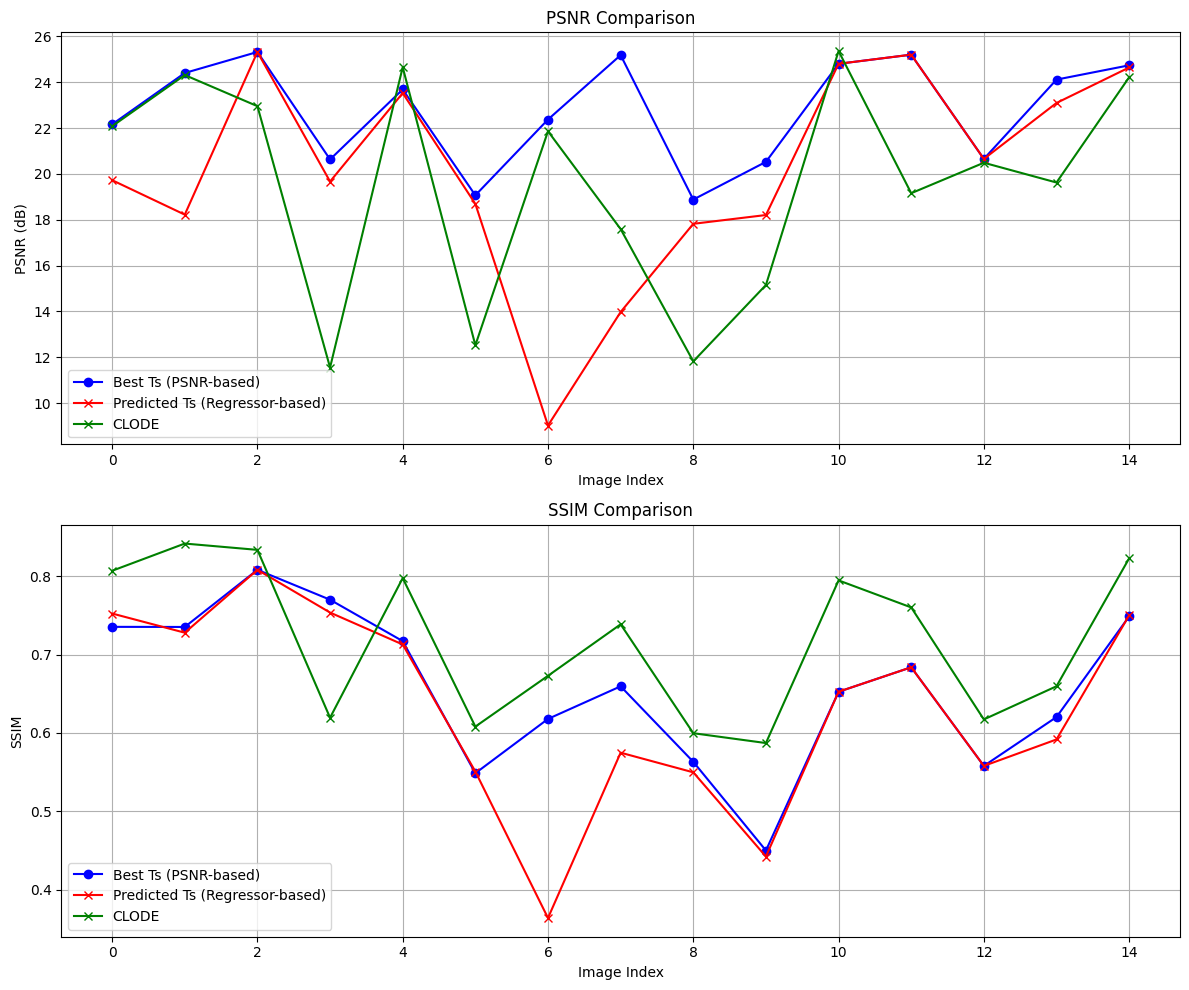

In [38]:
# eval15 데이터 경로 설정
eval_path = Path('/home/lbw/data/eval15')
eval_images = [f for f in sorted(os.listdir(eval_path / 'LOL')) if f.lower().endswith('.png')]

def load_eval_image(idx):
    img_name = eval_images[idx]
    lq_img = image_tensor(eval_path / 'LOL' / img_name)
    gt_img = image_tensor(eval_path / 'high' / img_name)
    
    return lq_img.to(device), gt_img.to(device), img_name


psnrs = []
ssims = []


for idx in tqdm(range(len(eval_images)), desc="NODE 모델 결과 생성 중"):
    lq_img, gt_img, img_name = load_eval_image(idx)
        # 모든 T에 대한 예측 수행
    with torch.no_grad():
        
        # 메트릭 계산
        psnr = calculate_psnr(lq_img, gt_img).item()
        ssim_value = calculate_ssim(lq_img, gt_img)
        # 결과 저장
        psnrs.append(psnr)
        ssims.append(ssim_value)

print(f"PSNR: {np.mean(psnrs):.4f}dB")
print(f"SSIM: {np.mean(ssims):.4f}")


# PSNR과 SSIM 결과를 시각화
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# PSNR 비교 그래프
ax1.plot(best_psnrs, label='Best Ts (PSNR-based)', marker='o', color='blue')
ax1.plot(pred_psnrs, label='Predicted Ts (Regressor-based)', marker='x', color='red')
ax1.plot(psnrs, label='CLODE', marker='x', color='green')
ax1.set_xlabel('Image Index')
ax1.set_ylabel('PSNR (dB)')
ax1.set_title('PSNR Comparison')
ax1.legend()
ax1.grid(True)

# SSIM 비교 그래프
ax2.plot(best_ssims, label='Best Ts (PSNR-based)', marker='o', color='blue')
ax2.plot(pred_ssims, label='Predicted Ts (Regressor-based)', marker='x', color='red')
ax2.plot(ssims, label='CLODE', marker='x', color='green')
ax2.set_xlabel('Image Index')
ax2.set_ylabel('SSIM')
ax2.set_title('SSIM Comparison')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig(results_dir / 'metrics_comparison.png')
plt.show()

In [ ]:
if

## 아래는 resize 전 후 Clip score 비교용

이미지 CLIP 점수 비교 중: 100%|██████████| 15/15 [00:12<00:00,  1.24it/s]



===== CLIP 점수 비교 요약 =====
이미지 수: 15

평균 CLIP 점수 차이 (원본 - 리사이즈):
밝기 점수 차이: 0.0007 ± 0.0027
노이즈 점수 차이: -0.0003 ± 0.0026
품질 점수 차이: 0.0003 ± 0.0006


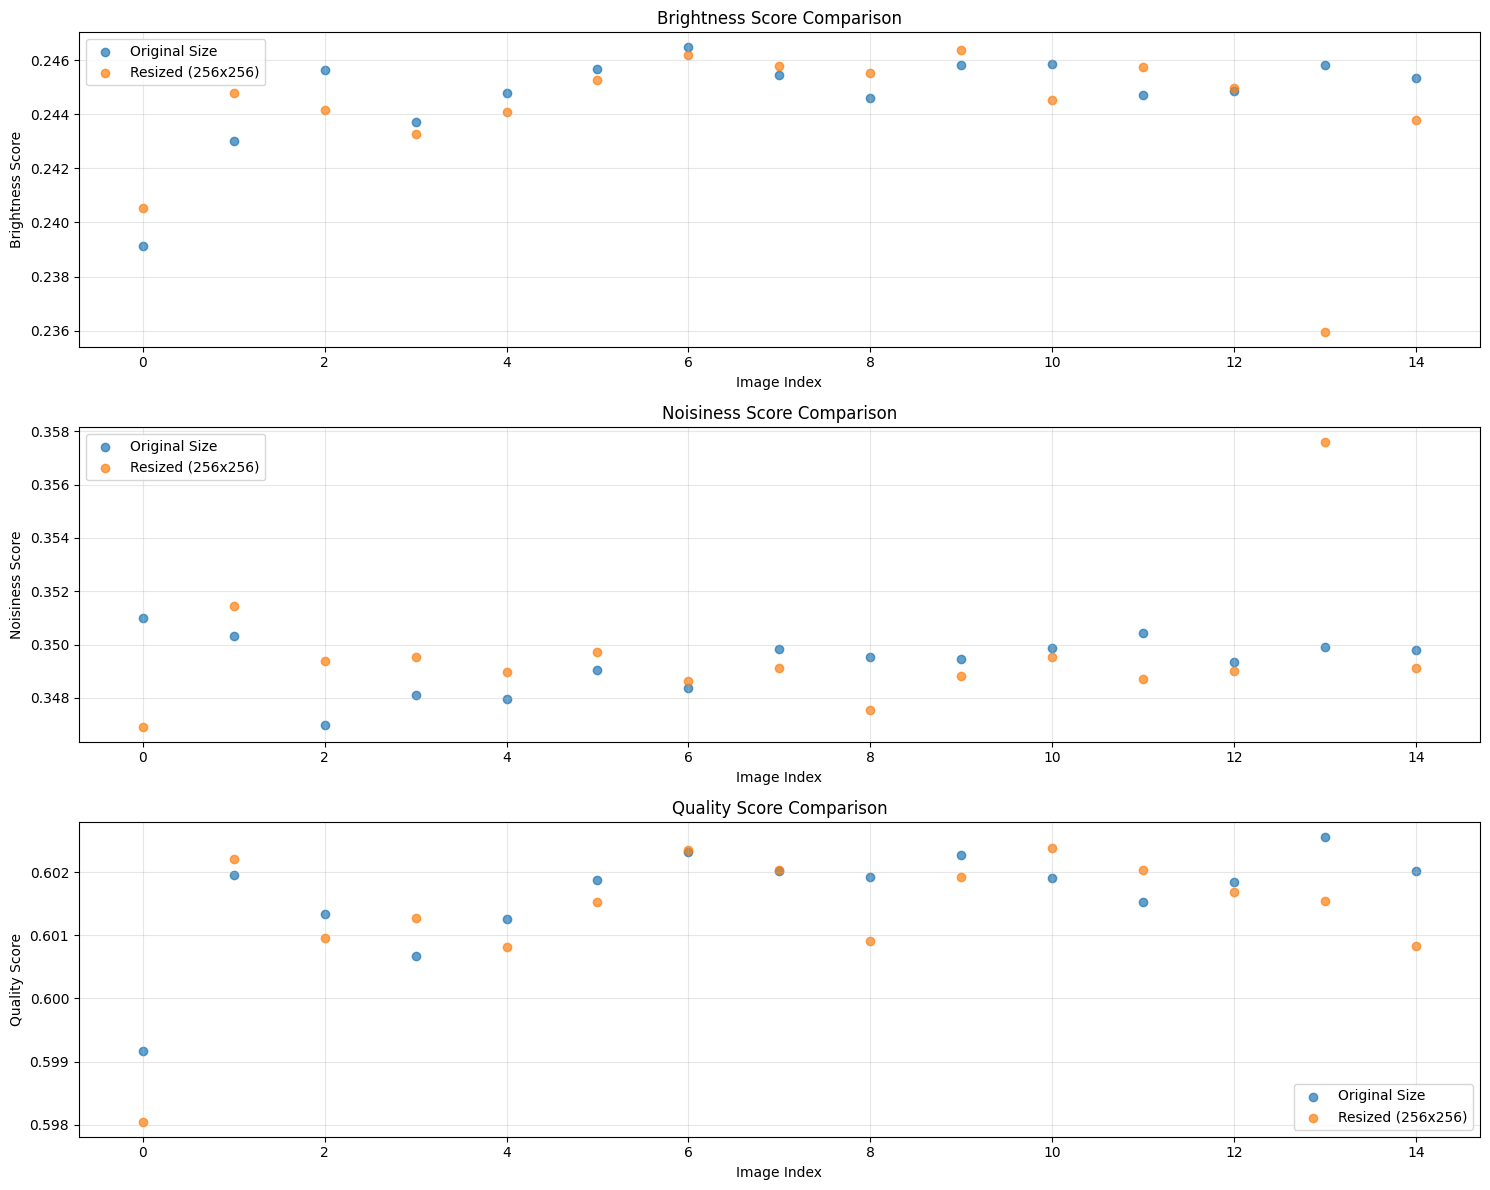


원본과 리사이즈 간 상관계수:
밝기 점수 상관계수: 0.2930
노이즈 점수 상관계수: 0.0634
품질 점수 상관계수: 0.8283


In [4]:
import torch
from torchmetrics.multimodal import CLIPImageQualityAssessment
from tqdm import tqdm
from misc import *
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
from pathlib import Path



os.environ["CUDA_VISIBLE_DEVICES"] = '3'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# CLIP 점수 계산을 위한 설정
prompts = ('brightness', 'noisiness', 'quality')
clip_metric = CLIPImageQualityAssessment(
    model_name_or_path="openai/clip-vit-base-patch16",
    prompts=prompts
).to(device)

def calculate_clip_score(pred):    
    if len(pred.shape) == 3:
        pred = pred.unsqueeze(0)
    
    with torch.no_grad():
        scores = clip_metric(pred)
    
    return scores[prompts[0]].item(), scores[prompts[1]].item(), scores[prompts[2]].item()

# eval15 데이터 경로 설정
eval_path = Path('/home/lbw/data/eval15')
eval_images = [f for f in sorted(os.listdir(eval_path / 'low')) if f.lower().endswith('.png')]

def load_eval_image_original(idx):
    """원본 크기 이미지 로드"""
    img_name = eval_images[idx]
    lq_img = image_tensor(eval_path / 'low' / img_name)
    gt_img = image_tensor(eval_path / 'high' / img_name)
    
    return lq_img.to(device), gt_img.to(device), img_name

def load_eval_image_resized(idx):
    """256x256 크기로 리사이즈된 이미지 로드"""
    img_name = eval_images[idx]
    lq_img = image_tensor(eval_path / 'low' / img_name, size=(256, 256))
    gt_img = image_tensor(eval_path / 'high' / img_name, size=(256, 256))
    
    return lq_img.to(device), gt_img.to(device), img_name

# 결과 저장 디렉토리
results_dir = Path('/home/lbw/CLODE/clip_score_comparison')
results_dir.mkdir(parents=True, exist_ok=True)

# 원본 크기와 리사이즈된 이미지의 CLIP 점수 비교
results = []

for idx in tqdm(range(len(eval_images)), desc="이미지 CLIP 점수 비교 중"):
    # 원본 크기 이미지 로드
    lq_img_orig, gt_img_orig, img_name = load_eval_image_original(idx)
    
    # 리사이즈된 이미지 로드
    lq_img_resized, gt_img_resized, _ = load_eval_image_resized(idx)
    
    # 원본 이미지 크기 저장
    original_shape = lq_img_orig.shape
    
    # 원본 크기 이미지의 CLIP 점수 계산
    bright_orig, noise_orig, quality_orig = calculate_clip_score(lq_img_orig)
    
    # 리사이즈된 이미지의 CLIP 점수 계산
    bright_resized, noise_resized, quality_resized = calculate_clip_score(lq_img_resized)
    
    # 결과 저장
    result = {
        'img_name': img_name,
        'original_size': f"{original_shape[2]}x{original_shape[3]}",
        'brightness_original': bright_orig,
        'noisiness_original': noise_orig,
        'quality_original': quality_orig,
        'brightness_resized': bright_resized,
        'noisiness_resized': noise_resized,
        'quality_resized': quality_resized,
        'brightness_diff': bright_orig - bright_resized,
        'noisiness_diff': noise_orig - noise_resized,
        'quality_diff': quality_orig - quality_resized
    }
    results.append(result)
    
    # 시각화 - 이미지와 점수 비교
    plt.figure(figsize=(15, 10))
    
    # 원본 이미지
    plt.subplot(2, 2, 1)
    img_np = lq_img_orig[0].detach().cpu().permute(1, 2, 0).numpy()
    img_np = np.clip(img_np, 0, 1)
    plt.imshow(img_np)
    plt.title(f'Original Size: {original_shape[2]}x{original_shape[3]}')
    plt.axis('off')
    
    # 리사이즈된 이미지
    plt.subplot(2, 2, 2)
    img_np = lq_img_resized[0].detach().cpu().permute(1, 2, 0).numpy()
    img_np = np.clip(img_np, 0, 1)
    plt.imshow(img_np)
    plt.title('Resized: 256x256')
    plt.axis('off')
    
    # 점수 비교 - 막대 그래프
    plt.subplot(2, 1, 2)
    x = np.arange(3)
    width = 0.35
    
    original_scores = [bright_orig, noise_orig, quality_orig]
    resized_scores = [bright_resized, noise_resized, quality_resized]
    
    plt.bar(x - width/2, original_scores, width, label='Original Size')
    plt.bar(x + width/2, resized_scores, width, label='Resized (256x256)')
    
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.xticks(x, ['Brightness', 'Noisiness', 'Quality'])
    plt.ylabel('CLIP Score')
    plt.title('CLIP Scores Comparison')
    plt.legend()
    
    # 점수 표시
    for i, v in enumerate(original_scores):
        plt.text(i - width/2, v + 0.02, f"{v:.3f}", ha='center')
    
    for i, v in enumerate(resized_scores):
        plt.text(i + width/2, v + 0.02, f"{v:.3f}", ha='center')
    
    plt.tight_layout()
    plt.savefig(results_dir / f'{img_name.split(".")[0]}_clip_comparison.png')
    plt.close()

# 결과를 DataFrame으로 변환
df = pd.DataFrame(results)

# 결과 저장
df.to_csv(results_dir / 'clip_scores_comparison.csv', index=False)

# 결과 요약
print("\n===== CLIP 점수 비교 요약 =====")
print(f"이미지 수: {len(results)}")
print("\n평균 CLIP 점수 차이 (원본 - 리사이즈):")
print(f"밝기 점수 차이: {df['brightness_diff'].mean():.4f} ± {df['brightness_diff'].std():.4f}")
print(f"노이즈 점수 차이: {df['noisiness_diff'].mean():.4f} ± {df['noisiness_diff'].std():.4f}")
print(f"품질 점수 차이: {df['quality_diff'].mean():.4f} ± {df['quality_diff'].std():.4f}")

# 전체 데이터셋의 CLIP 점수 분포 시각화
plt.figure(figsize=(15, 12))

# 밝기 비교
plt.subplot(3, 1, 1)
plt.scatter(df.index, df['brightness_original'], alpha=0.7, label='Original Size')
plt.scatter(df.index, df['brightness_resized'], alpha=0.7, label='Resized (256x256)')
plt.xlabel('Image Index')
plt.ylabel('Brightness Score')
plt.title('Brightness Score Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# 노이즈 비교
plt.subplot(3, 1, 2)
plt.scatter(df.index, df['noisiness_original'], alpha=0.7, label='Original Size')
plt.scatter(df.index, df['noisiness_resized'], alpha=0.7, label='Resized (256x256)')
plt.xlabel('Image Index')
plt.ylabel('Noisiness Score')
plt.title('Noisiness Score Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# 품질 비교
plt.subplot(3, 1, 3)
plt.scatter(df.index, df['quality_original'], alpha=0.7, label='Original Size')
plt.scatter(df.index, df['quality_resized'], alpha=0.7, label='Resized (256x256)')
plt.xlabel('Image Index')
plt.ylabel('Quality Score')
plt.title('Quality Score Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(results_dir / 'overall_clip_comparison.png')
plt.show()

# 상관 분석
corr_bright = df['brightness_original'].corr(df['brightness_resized'])
corr_noise = df['noisiness_original'].corr(df['noisiness_resized'])
corr_quality = df['quality_original'].corr(df['quality_resized'])

print("\n원본과 리사이즈 간 상관계수:")
print(f"밝기 점수 상관계수: {corr_bright:.4f}")
print(f"노이즈 점수 상관계수: {corr_noise:.4f}")
print(f"품질 점수 상관계수: {corr_quality:.4f}")